In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [4]:
fly_num = 'fly_180'
func_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/func_0/'
# fly_num = 'fly_193'
# func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/func_0'

In [5]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 741 presented stimuli.
starts_angle_0: 184. starts_angle_180: 184


In [6]:
for file in os.listdir(vision_path):
    if file[-4:] == 'hdf5':
        file_name = file

visprotocol_file = os.path.join(vision_path, file_name)
with h5py.File(visprotocol_file, 'r') as file:
    angle = file['angle'][:]
    translation = file['translation'][:]

In [7]:
stim_time = 0.75 #0.5 will be in hold
post_time = 1.25
# How long should a cluster of epochs be?
epoch_cluster_duration = 6.25 #in min # THIS IS SET BASED ON 5 1MIN GREY PERIODS AND 4 STIM PERIODS FOR 30MIN TOTAL
epoch_cluster_duration *= 60 # now in sec

###############################################
### CREATE LONG LIST OF ALL STIM TO PRESENT ###
###############################################

epoch_duration = post_time + stim_time
# given the duration of a single epoch and a cluster of epochs, how many epochs to present?
num_epochs_in_cluster = int(epoch_cluster_duration / epoch_duration)
num_single_stim_type = int(num_epochs_in_cluster/4)

In [8]:
starts_loom = []
for i in range(len(angles)):
    if angles[i] == None:
        continue
    if np.isnan(angles[i]):
        starts_loom.append(int(stimulus_start_times[i]*100))

In [9]:
#QC to check if flies actually responding to loom
max_time = np.max(starts_loom)
min_time = 1
null_times = np.random.randint(min_time, max_time, len(starts_loom))
# this replaces starts_loom

In [10]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [11]:
def extract_traces(fictrac, stim_times, pre_window, post_window):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac['Y'][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [12]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
# stim_time = 75

behavior_traces = {}
mean_trace = {}
sem_trace = {}
#for angle in [0,180]:
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac, starts_loom, pre_window, post_window)
behavior_traces_QC,mean_trace_QC,sem_trace_QC = extract_traces(fictrac, null_times, pre_window, post_window)

(array([ 1.,  5., 13., 23., 84., 37., 14.,  5.,  0.,  2.]),
 array([-11.26400158,  -8.90885294,  -6.55370431,  -4.19855568,
         -1.84340705,   0.51174158,   2.86689021,   5.22203885,
          7.57718748,   9.93233611,  12.28748474]),
 <BarContainer object of 10 artists>)

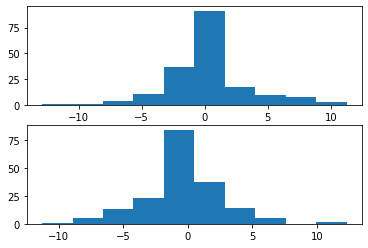

In [13]:
rand_time_e = 250
rand_time_s = 210
diffs = behavior_traces[:,rand_time_e]-behavior_traces[:,rand_time_s]
diffs_QC = behavior_traces_QC[:,rand_time_e]-behavior_traces_QC[:,rand_time_s]
plt.subplot(2, 1, 1)
plt.hist(diffs)
plt.subplot(2, 1, 2)
plt.hist(diffs_QC)

In [14]:
ts = fictrac_raw["timeStamp"] #in ms i think
ts_sec = ts/1000
fr = 1/np.mean(np.diff(ts_sec)) #figure out frame_rate from bruker fictrac

In [15]:
len(ts_sec) #number of frames (should be 180000 for 30min)

180000

In [16]:
fr

99.99916666262371

In [17]:
# andrew anaylsis
value_struct ={
    # the data is in 10ms, use this value to get the index if i use seconds
    "tp_width_sec": 0.01,
    "trial_time_sec": 1,
    "before_stim_sec": pre_window/100,
    # time in seconds between end of pre trial window and the stimulus time. 
    # when set to zero, the pre trial window ends when the stimulus is presented
    "pre_trial_window_sec": -0.05,
    # size of window that pre trial speed is averaged over, seconds, window ends at stimulus time
    # when 0 is a single val and not a window
    "pre_trial_size_sec": 0,
    # size of post trial speed average window, sec
    "post_trial_window_sec": 0.5,
    # post trial window at stim tiem + post trail delay
    # when 0 is a single val and not a window
    "post_trial_size_sec": 0,
    "thresh": 0.05
    }
def get_vals_for_analysis(tp_width_sec=0, trial_time_sec=0, before_stim_sec=0, pre_trial_window_sec=0, pre_trial_size_sec=0, post_trial_window_sec=0, post_trial_size_sec=0, thresh=0):
        
    stim_end_sec = before_stim_sec + trial_time_sec
    
    stim_idx = int(before_stim_sec/tp_width_sec)
    stim_end_idx = int(stim_end_sec/tp_width_sec)
    pre_trial_window_idx = int(pre_trial_window_sec/tp_width_sec)

    # first val i use to make delta to compare change in vel
    first_val_end_idx = int(stim_idx - pre_trial_window_idx)
    first_val_start_idx = int(first_val_end_idx - (pre_trial_size_sec/tp_width_sec)) #only needed if you're averaging across a window, otherwise just start val is used

    # second val used to make delta
    second_val_start_idx = int(stim_idx + post_trial_size_sec/tp_width_sec)
    second_val_end_idx = int(second_val_start_idx + post_trial_window_sec/tp_width_sec)
    return stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx

In [18]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

In [19]:
def apply_butter_lowpass(behavior_traces, stim_idx, fr):
    # Filter requirements.
    order = 4
    fs = fr      # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, fs=fs, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(w, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    # plt.grid()

    # Filter the data, and plot both the original and filtered signals.
    lpf_behavior = np.zeros((behavior_traces.shape[0], behavior_traces.shape[1] - stim_idx))

    for i in range(behavior_traces.shape[0]):
        lpf_behavior[i, :] = butter_lowpass_filter(behavior_traces[i,stim_idx:], cutoff, fs, order)

    plt.subplot(2, 1, 2)
    plt.plot(np.mean(behavior_traces[:, stim_idx:], axis=0), 'b-', label='data')
    plt.plot(np.mean(lpf_behavior, axis=0), 'g-', linewidth=2, label='filtered data')
    # plt.plot(np.mean(lpf_behavior_QC, axis=0), 'r-', linewidth=2, label='QC filtered data')
    plt.xlabel('Time')
    # plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()
    return lpf_behavior

In [20]:
# # (n_trials,)
# if PRE_TRIAL_START_IDX!=PRE_TRIAL_END_IDX:
#     pre_trial_speed = np.mean(behavior_traces[:, PRE_TRIAL_START_IDX:PRE_TRIAL_END_IDX], axis=1)
# else:
#     pre_trial_speed = np.asarray(behavior_traces[:, PRE_TRIAL_START_IDX])
# # (n_trials,)
# if POST_TRIAL_START_IDX!=POST_TRIAL_END_IDX:
#     post_trial_speed = np.mean(behavior_traces[:, POST_TRIAL_START_IDX:POST_TRIAL_END_IDX], axis=1)
# else:
#     post_trial_speed = np.asarray(behavior_traces[:, POST_TRIAL_START_IDX])


In [21]:
def get_speed_change(behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx):
    pre_tsi= first_val_start_idx-stim_idx
    pre_tei = first_val_end_idx-stim_idx
    post_tsi = second_val_start_idx-stim_idx
    post_tei = second_val_end_idx-stim_idx
    
    if first_val_start_idx!=first_val_end_idx:
        first_speed = np.mean(behavior[:,pre_tsi:pre_tei], axis = 1)
    else:
        first_val_start_idx = int(first_val_start_idx)
        first_speed = np.asarray(behavior[:,pre_tsi])

    if second_val_start_idx!=second_val_end_idx:
        second_speed = np.mean(behavior[:,post_tsi:post_tei], axis = 1)
    else: 
        second_speed = np.asarray(behavior[:,post_tsi])
    speed_change = second_speed-first_speed
    return speed_change

In [22]:
# # (n_trials,) positive if they start slow and end fast, negative for vice versa
# speed_change = post_trial_speed - pre_trial_speed

In [23]:
# plt.plot(speed_change)

In [24]:
# SLOW_TRIAL_SELECTION = np.logical_not(speed_change < SPEED_THRESHOLD)
# SLOW_TRIAL_IDXS = np.where(SLOW_TRIAL_SELECTION)[0]
# slow_ind = SLOW_TRIAL_IDXS

In [25]:
# fig, ax = plt.subplots()

# ax.hist(speed_change, bins = 50)

In [26]:
def get_trials(speed_change, thresh):
    decrease_trials = speed_change <-thresh
    decrease_idx = np.where(decrease_trials)
    increase_trials = speed_change>thresh
    increase_idx = np.where(increase_trials)
    flat_trials = np.logical_and(speed_change>-thresh, speed_change<thresh)
    flat_idx = np.where(flat_trials)
    return increase_trials, decrease_trials, flat_trials

# OLD

##Find the indicies of trials where the speed decreased past a certain threshold (presumed freezing)
diffs = behavior_traces[:,pre_window] - behavior_traces[:,(pre_window+avg_around)]
plt.plot(diffs)
print(np.size(diffs))
threshold = 0.001
slow_ind = np.where(diffs>threshold)[0]
for idx in slow_ind:
    plt.axvline(idx,color='r',linestyle='--',lw=1)

In [27]:

def validate_trial(trial_idx, trace=None):
    """ Visualize a single trial, along with the pre and post averaging windows
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    if trace is None:
        trace = behavior_traces[trial_idx]
    plt.plot(trace)
    plt.axvline(first_val_start_idx, color='r')
    plt.axvline(first_val_end_idx, color='r')
    plt.axvline(second_val_start_idx, color='y')
    plt.axvline(second_val_end_idx, color='y')
    plt.axvline(stim_idx, color='b')


def validate_windows(behavior_traces, value_struct, fr):
    """ Visualize average traces for both slow and fast trials
    
    NOTE: uses global variables, must rerun constant cells and slow_ind logic to change results.
    
    RED: pre window
    YELLOW: post window
    BLUE: stim time
    """
    
    stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
    lpf_behavior = apply_butter_lowpass(behavior_traces, stim_idx, fr)
    speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
    increase_trials, decrease_trials, flat_trials = get_trials(speed_change, value_struct["thresh"])
    increase_traces = behavior_traces[increase_trials]
    decrease_traces = behavior_traces[decrease_trials]
    flat_traces = behavior_traces[flat_trials]
    
    print(f"{len(increase_traces)} increase trials")
    print(f"{len(decrease_traces)} decrease trials")
    print(f"{len(flat_traces)} flat trials")
    
    increase_mean = np.mean(increase_traces, axis=0)
    increase_sem = scipy.stats.sem(increase_traces, axis=0)
    
    decrease_mean = np.mean(decrease_traces, axis=0)
    decrease_sem = scipy.stats.sem(decrease_traces, axis=0)
    
    flat_mean = np.mean(flat_traces, axis=0)
    flat_sem = scipy.stats.sem(flat_traces, axis=0)
    
    fig, axes = plt.subplots(nrows=3)
    
    axes[0].plot(increase_mean, color='k',linewidth=3)
    axes[0].set_ylim(-1, 3.5)
    axes[0].fill_between(np.arange(len(increase_mean)), increase_mean - increase_sem, increase_mean + increase_sem, color='k',alpha=0.3)
    axes[0].axvline(first_val_start_idx, color='r')
    axes[0].axvline(first_val_end_idx, color='r')
    axes[0].axvline(second_val_start_idx, color='y')
    axes[0].axvline(second_val_end_idx, color='y')
    axes[0].axvline(stim_idx, color='b', linestyle='--')
    axes[0].axvline(stim_end_idx, color='b', linestyle='--')
#     axes[0].set_title("slow trials")
    

    
    axes[1].plot(decrease_mean, color='k',linewidth=3)
    axes[1].set_ylim(-1, 3.5)
    axes[1].fill_between(np.arange(len(decrease_mean)), decrease_mean - decrease_sem, decrease_mean + decrease_sem, color='k',alpha=0.3)
    axes[1].axvline(first_val_start_idx, color='r')
    axes[1].axvline(first_val_end_idx, color='r')
    axes[1].axvline(second_val_start_idx, color='y')
    axes[1].axvline(second_val_end_idx, color='y')
    axes[1].axvline(stim_idx, color='b', linestyle='--')
    axes[1].axvline(stim_end_idx, color='b', linestyle='--')
    
    axes[2].plot(flat_mean, color='k',linewidth=3)
    axes[2].set_ylim(-1, 3.5)
    axes[2].fill_between(np.arange(len(flat_mean)), flat_mean - flat_sem, flat_mean + flat_sem, color='k',alpha=0.3)
    axes[2].axvline(first_val_start_idx, color='r')
    axes[2].axvline(first_val_end_idx, color='r')
    axes[2].axvline(second_val_start_idx, color='y')
    axes[2].axvline(second_val_end_idx, color='y')
    axes[2].axvline(stim_idx, color='b', linestyle='--')
    axes[2].axvline(stim_end_idx, color='b', linestyle='--')
    
    return fig, axes


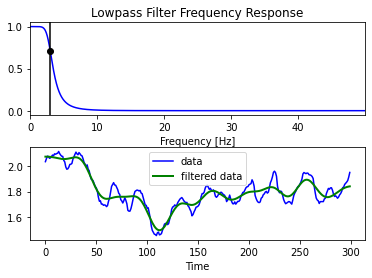

76 increase trials
92 decrease trials
16 flat trials


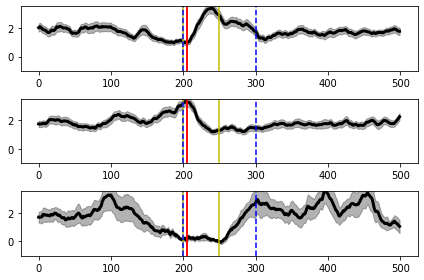

In [28]:
fig, axes = validate_windows(behavior_traces_QC,value_struct, fr)
fig.tight_layout()

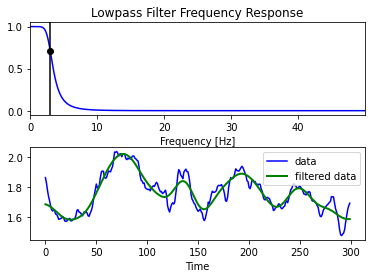

79 increase trials
86 decrease trials
19 flat trials


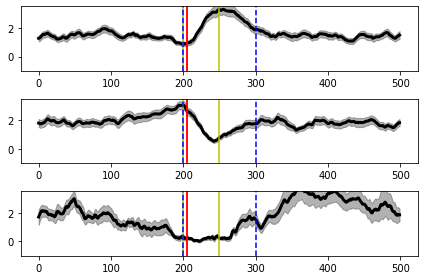

In [29]:
fig, axes = validate_windows(behavior_traces,value_struct, fr)
fig.tight_layout()

NameError: name 'STIM_IDX' is not defined

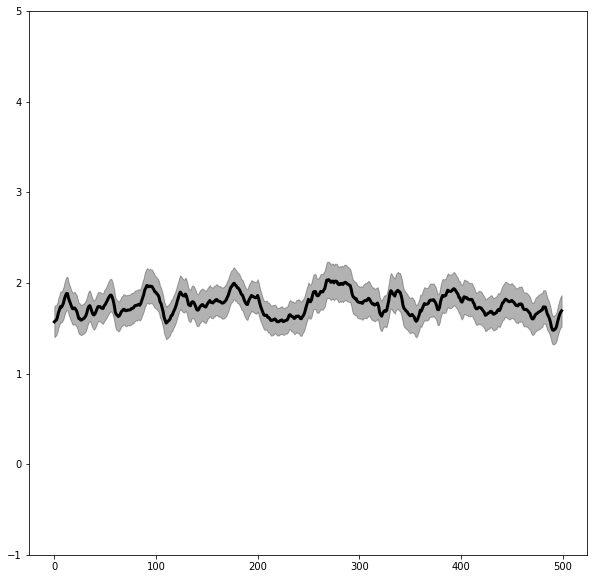

In [30]:
# plotting all average behavior around the looming stim
plt.figure(figsize=(10,10))
plt.plot(mean_trace,color='k',linewidth=3)
plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
plt.ylim(-1, 5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)

    

In [31]:
#Only plotting behavior of the trials where the fly froze

decrease_traces = behavior_traces[decrease_trials]
decrease_mean = np.mean(decrease_traces, axis=0)
decrease_sem = scipy.stats.sem(decrease_traces, axis=0)

plt.figure(figsize=(10,10))
plt.plot(decrease_mean,color='k',linewidth=3)
plt.fill_between(np.arange(len(decrease_mean)),decrease_mean-decrease_sem, decrease_mean+decrease_sem, color='k',alpha=0.3)
plt.ylim(-1, 3.5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)
np.shape(decrease_traces)

NameError: name 'decrease_trials' is not defined

In [ ]:
#Only plotting behavior of the trials where the fly didn't freeze

increase_traces = behavior_traces[increase_trials]
increase_mean = np.mean(increase_traces, axis=0)
increase_sem = scipy.stats.sem(increase_traces, axis=0)

plt.figure(figsize=(10,10))
plt.plot(increase_mean,color='k',linewidth=3)
plt.fill_between(np.arange(len(increase_mean)),increase_mean-increase_sem, increase_mean+increase_sem, color='k',alpha=0.3)
plt.ylim(-1, 3.5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)
np.shape(increase_traces)

In [ ]:
#Only plotting behavior of the trials where the fly didn't move much

flat_traces = behavior_traces[flat_trials]
flat_mean = np.mean(flat_traces, axis=0)
flat_sem = scipy.stats.sem(flat_traces, axis=0)

plt.figure(figsize=(10,10))
plt.plot(flat_mean,color='k',linewidth=3)
plt.fill_between(np.arange(len(flat_mean)),flat_mean-flat_sem, flat_mean+flat_sem, color='k',alpha=0.3)
plt.ylim(-1, 3.5)
plt.axvline(STIM_IDX,color='k',linestyle='--',lw=2)
plt.axvline(STIM_END_IDX,color='k',linestyle='--',lw=2)
np.shape(flat_traces)

# load neural

In [ ]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [ ]:
np.shape(all_signals)

In [ ]:
time_average =np.mean(all_signals, axis=(0,1))

# Fictrac checks

In [ ]:
fictrac['Y'] = np.squeeze(fictrac['Y'])
out = scipy.signal.correlate(time_average, fictrac['Y'])

In [ ]:
plt.plot(out)
plt.axvline(3384,color='k')
plt.xlim(3300,3400)

# check warp quality

In [ ]:
fixed = brainsss.load_fda_meanbrain()

In [ ]:
fixed

In [ ]:
atlas = brainsss.load_roi_atlas()

In [ ]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [ ]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

In [ ]:
fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [ ]:
warp_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/warp/'
f2a = ants.image_read(os.path.join(warp_dir, 'func-to-anat.nii'))

In [ ]:
plt.imshow(f2a[:,:,70].T)

In [ ]:
warp_dir = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/warp/'
a2a = ants.image_read(os.path.join(warp_dir, 'anat-to-meanbrain.nii'))

In [ ]:
a2a

In [ ]:
directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly_num}/anat_0/moco'
anat = ants.image_read(os.path.join(directory, 'anatomy_channel_1_moc_mean.nii'))

In [ ]:
anat.set_spacing((0.653, 0.653, 1))

In [ ]:
anat_low=anat.resample_image((2,2,2),use_voxels=False)

In [ ]:
z=20
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(a2a[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(fixed[:,:,z].T)

In [ ]:
bin_start = -500; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

# STA wrapped

In [ ]:
starts_loom_ms = [i*10 for i in starts_loom]

In [ ]:
decrease_starts = []
for idx in decrease_idx[0]:
    decrease_starts.append(starts_loom[idx])
decrease_starts_ms = [n*10 for n in decrease_starts]
print(np.shape(decrease_starts_ms))

increase_starts = []
for idx in increase_idx[0]:
    increase_starts.append(starts_loom[idx])
increase_starts_ms = [n*10 for n in increase_starts]
print(np.shape(increase_starts_ms))

flat_starts = []
for idx in flat_idx[0]:
    flat_starts.append(starts_loom[idx])
flat_starts_ms = [n*10 for n in flat_starts]
print(np.shape(flat_starts_ms))

In [ ]:
t0 = time.time()
STA_brain_decrease = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = decrease_starts_ms,
                                   neural_bins = neural_bins)

STA_brain_increase = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = increase_starts_ms,
                                   neural_bins = neural_bins)

STA_brain_flat = brainsss.make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = flat_starts_ms,
                                   neural_bins = neural_bins)
print(F'STA {time.time()-t0}')

In [ ]:
STA_brain_decrease = np.nan_to_num(STA_brain_decrease)
STA_brain_increase = np.nan_to_num(STA_brain_increase)
STA_brain_flat = np.nan_to_num(STA_brain_flat)

In [ ]:
reformed_STA_brain_decrease = brainsss.STA_supervoxel_to_full_res(STA_brain_decrease, cluster_labels)
reformed_STA_brain_increase = brainsss.STA_supervoxel_to_full_res(STA_brain_increase, cluster_labels)
reformed_STA_brain_flat = brainsss.STA_supervoxel_to_full_res(STA_brain_flat, cluster_labels)

In [ ]:
reformed_STA_brain = reformed_STA_brain_non_freeze-reformed_STA_brain_freeze
#to subract the different trials

In [ ]:
plt.imshow(reformed_STA_brain[25,13,:,:].T,)
# plt.imshow(reformed_STA_brain_non_freeze[25,13,:,:].T,)

In [ ]:
#change the STA brain based on condition
STA_brain = gaussian_filter1d(reformed_STA_brain_decrease,sigma=1,axis=1,truncate=1)

In [ ]:
t0 = time.time()
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly=fly_num, fixed=fixed, anat_to_mean_type='myr')
print(F'Warps {time.time()-t0}')

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

In [ ]:
ilana_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
if os.path.exists(ilana_path)==False:
    os.mkdir(ilana_path)


In [ ]:
movie_dir = os.path.join(ilana_path, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

In [ ]:
save_dir = os.path.join(movie_dir,'decrease')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')